## 1. Data Preparation

So far we've assumed that we already have access to a dataset that is ready to be used for training a machine learning model. However, in practice, this is rarely the case. Most of the time, the dataset will need to be cleaned, transformed, and prepared before it can be used for training.

**Stages of data preparation:**
1. Data collection
2. Data loading
3. Data exploration
4. Data cleaning
5. Feature selection and engineering
7. Encoding categorical variables
8. Feature scaling
9. Data splitting

### 1.1 Data Collection

Data collection is the process of gathering data from various sources. The data can be collected from databases, files, APIs, web scraping, etc. Outside of the scope of this notebook, but it's an important step in the data preparation process.

### 1.2 Data Loading

In this step, we load the data into the working environment. Your data might be in a CSV file, a JSON file, a SQL database, or any other format. We will use the `pandas` library to load the data into a DataFrame. Let's use the "Heart Failure Clinical Records" dataset from the UCI Machine Learning Repository. This dataset contains the medical records of patients who had heart failure, collected during their follow-up period.

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(url)

Note that we're lucky in this dataset, in that it is small enough to fit into memory. For larger datasets, we would need to use more advanced techniques to load the data in chunks. For example, we might use Dask rather than pandas, which would allow us to work with larger-than-memory datasets. (Dask is designed to be a drop-in replacement for pandas for larger-than-memory datasets, so the code would look very similar.)

For very large datasets, when performing data exploration and when producing the code that will be used to prepare your data, you might want to work with a sample of the data rather than the full dataset. This will allow you to iterate more quickly and avoid long wait times. Once you have the code working with a sample, you can then run it on the full dataset.

In [111]:
## Load only a subset of the dataset
small_df = pd.read_csv(url, nrows=20)

# Display the shape of the datasets
print(df.shape)
print(small_df.shape)

# We'll work with the full dataset, so let's delete the small_df
del small_df

(299, 13)
(20, 13)


### 1.3 Data Exploration

Data exploration is the process of getting to know the data. We look at the structure of the data, the summary statistics, and the distribution of the data. We also look for missing values, outliers, and anomalies in the data. This step is crucial for understanding the data and making decisions about how to clean and transform it.

It cannot be overemphasized that there is no one-size-fits-all approach to data exploration. The process will depend on the dataset, the problem you are trying to solve, and the questions you are trying to answer. A thorough understanding of the data -- its sources, its structure, its quality -- is essential for building a successful machine learning model.

In [112]:
# Get some basic information about the dataset

# Display the column names
print(df.columns)

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')


If you were really working with this dataset for research purposes, you should know what each of these columns represents, as well as the units in which they are measured. That knowledge is crucial both for knowing how best to make use of the data, as well as for detecting problems in the data.

In [113]:
# Display basic information
print(df.info())
print("\nSample data:")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None

Sample data:

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [114]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.0

In [115]:
# The real data is very clean already. Let's introduce some missing values, and also some outliers.
# We'll do this by randomly selecting some values and setting them to NaN, and also by adding some random noise to some values.

# Randomly select 10% of the data and set them to NaN
df_nan = df.copy()
nan_indices = np.random.choice(df.index, size=int(len(df)*0.1), replace=False)
df_nan.loc[nan_indices, 'age'] = np.nan
df_nan.loc[nan_indices, 'serum_creatinine'] = np.nan
df_nan.loc[nan_indices, 'ejection_fraction'] = np.nan

# Randomly select 2% of the data and make them outliers
df_noisy = df_nan.copy()
noisy_indices = np.random.choice(df.index, size=int(len(df)*0.02), replace=False)
df_noisy.loc[noisy_indices, 'serum_creatinine'] = df_noisy.loc[noisy_indices, 'serum_creatinine'] * 10
df_noisy.loc[noisy_indices, 'ejection_fraction'] = df_noisy.loc[noisy_indices, 'ejection_fraction'] * 10

# Display the first few rows of the noisy dataset
print("\nNoisy dataset:")
df_noisy.head()


Noisy dataset:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20.0,1,265000.00,1.9,130,1,0,4,1
1,NaN,0,7861,0,NaN,0,263358.03,NaN,136,1,0,6,1
2,65.0,0,146,0,20.0,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20.0,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20.0,0,327000.00,2.7,116,0,0,8,1


In [116]:
# Check for missing values
print("\nMissing values:")
print(df_noisy.isnull().sum())


Missing values:
age                         29
anaemia                      0
creatinine_phosphokinase     0
diabetes                     0
ejection_fraction           29
high_blood_pressure          0
platelets                    0
serum_creatinine            29
serum_sodium                 0
sex                          0
smoking                      0
time                         0
DEATH_EVENT                  0
dtype: int64


Suppose that our target variable is the "DEATH_EVENT" column, which indicates whether the patient died during the follow-up period. We will explore the data to understand the relationships between the features and the target variable.

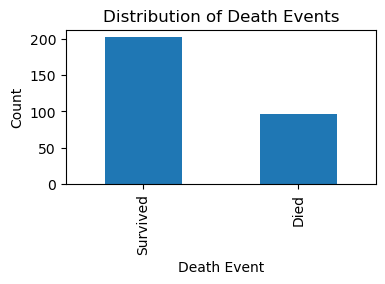

Percentage of deaths: 32.10702341137124 %


In [117]:
plt.figure(figsize=(4, 2))
df_noisy['DEATH_EVENT'].value_counts().plot(kind='bar')
plt.title('Distribution of Death Events')
plt.xlabel('Death Event')
plt.ylabel('Count')
plt.xticks([0, 1], ['Survived', 'Died'])
plt.show()

print("Percentage of deaths:", (df['DEATH_EVENT'].sum() / len(df)) * 100, "%")

Let's look at the age distribution across the dataset. While we're at it, let's break it down by our target variable, `DEATH_EVENT`.

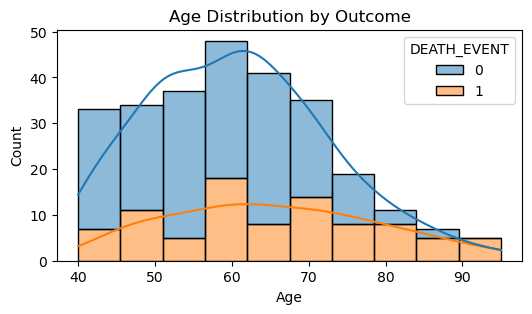

Average age of survivors: 58.46408839779006
Average age of non-survivors: 65.5468202247191


In [118]:
plt.figure(figsize=(6, 3))
sns.histplot(data=df_noisy, x='age', hue='DEATH_EVENT', kde=True, multiple="stack")
plt.title('Age Distribution by Outcome')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print("Average age of survivors:", df_noisy[df_noisy['DEATH_EVENT'] == 0]['age'].mean())
print("Average age of non-survivors:", df_noisy[df_noisy['DEATH_EVENT'] == 1]['age'].mean())

Very frequently, a correlation heatmap is a good way to get a quick overview of the relationships between the features in the dataset. Note that this assumes that the features are all numeric. If you have categorical features, you will need to encode them as numbers before you can use a correlation heatmap.

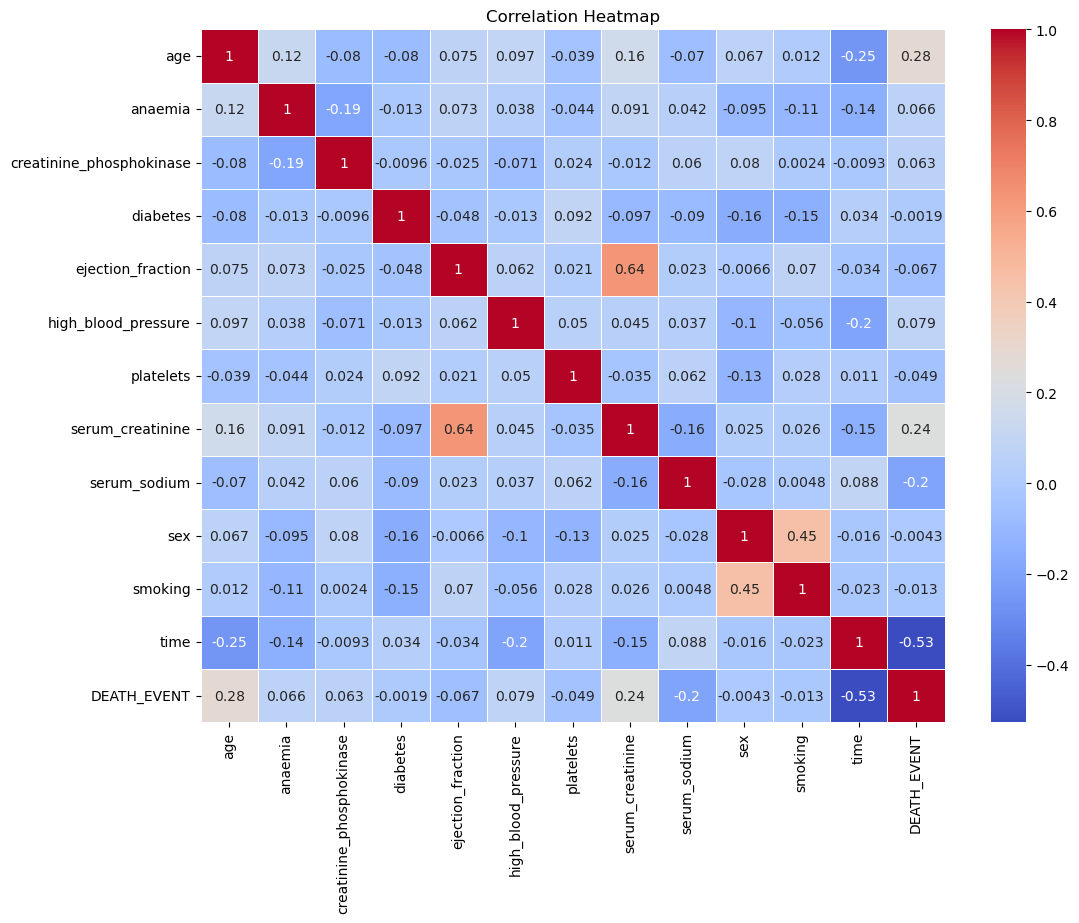

In [119]:
plt.figure(figsize=(12, 9))
sns.heatmap(df_noisy.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

You might want to look at scatterplots to see if you pick up on any patterns in the data (or verify that patterns you expect to be there are really there).

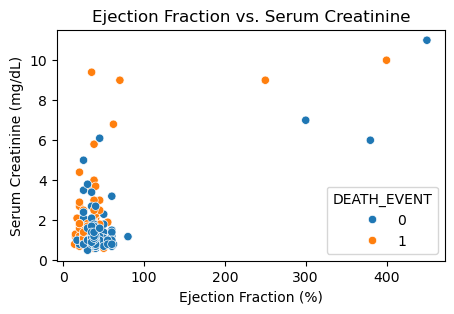

In [120]:
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_noisy, x='ejection_fraction', y='serum_creatinine', hue='DEATH_EVENT')
plt.title('Ejection Fraction vs. Serum Creatinine')
plt.xlabel('Ejection Fraction (%)')
plt.ylabel('Serum Creatinine (mg/dL)')
plt.show()

What! There are some datapoints that look like bad outliers, before we even check what they are. And in this case, they are percentages that are well above 100%. Something is definitely wrong with those datapoints.

### 1.4 Data Cleaning

First we'll check for and handle outliers. We need to be thoughtful about this step! Every choice we make says something about how we expect the future data to look, and what we think is the reason why we have outliers in our data.

In [121]:
# Check for outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_noisy[(df_noisy[column] < lower_bound) | (df_noisy[column] > upper_bound)]
    return outliers

# Example: Check outliers in 'serum_creatinine'
creatinine_outliers = detect_outliers(df_noisy, 'serum_creatinine')
print("Outliers in serum_creatinine:")
print(creatinine_outliers[['age', 'sex', 'serum_creatinine', 'DEATH_EVENT']])

# Remove outliers (be cautious with this step in real-world scenarios!)
df_cleaned = df_noisy[~df_noisy.index.isin(creatinine_outliers.index)]

print("\nDataset shape after cleaning:", df_cleaned.shape)

Outliers in serum_creatinine:
      age  sex  serum_creatinine  DEATH_EVENT
4    65.0    0               2.7            1
9    80.0    1               9.4            1
10   75.0    1               4.0            1
26   95.0    0              10.0            1
28   58.0    1               5.8            1
31   85.0    1               3.0            1
35   69.0    1               3.5            1
39   60.0    0               3.0            1
46   51.0    1               9.0            1
48   80.0    1               4.4            1
52   60.0    0               6.8            1
56   70.0    1               2.7            0
65   60.0    1               2.9            1
78   75.0    1               6.0            0
82   60.0    0               2.5            1
117  85.0    0               3.2            0
124  60.0    1               3.7            1
129  53.0    1               3.4            0
131  60.0    1               6.1            0
145  50.0    1               7.0            0
150 

Similarly, we must handle missing values in a way that is thoughtful about why the values might be missing. Are they missing at random? Are they missing because they are not applicable? Are they missing because they were never recorded? The answers to these questions will affect how we handle the missing values.

In [122]:
# Handle missing values

# Fill missing values with the mean
df_cleaned = df_cleaned.fillna(df_cleaned.mean())

# Alternatively, fill missing values with the median
# df_imputed = df_cleaned.fillna(df_cleaned.median())

# Or, if we're dealing with categorical data, we can fill missing values with the mode
# df_imputed = df_cleaned.fillna(df_cleaned.mode().iloc[0])

# We could also fit a machine learning model to predict missing values, but this is more complex and not always necessary.

# Check if there are any missing values left
print("\nMissing values after imputation:")
print(df_cleaned.isnull().sum())




Missing values after imputation:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### 1.5 Feature Selection and Engineering

Feature selection is the process of selecting a subset of relevant features for use in model training. Feature engineering is the process of creating new features from the existing features in the dataset. Both of these processes are crucial for building a successful machine learning model.

New features added:
     age_group  multiple_conditions  log_creatinine  ef_creatinine_interaction
0      Elderly                    1        6.368187                  38.000000
1       Senior                    0        8.969796                  44.223065
2       Senior                    1        4.990433                  26.000000
3  Middle-aged                    0        4.718499                  38.000000
5      Elderly                    1        3.871201                  84.000000


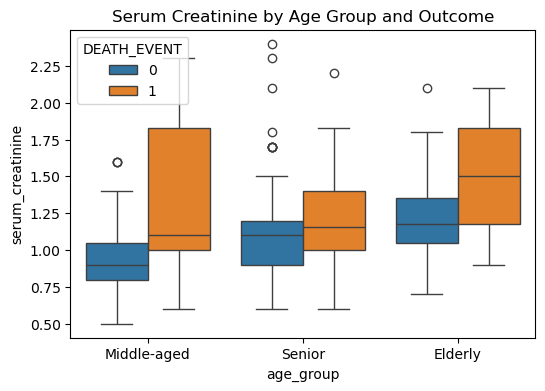

In [123]:
# Create age groups
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[30, 50, 70, 100], labels=['Middle-aged', 'Senior', 'Elderly'])

# Create a feature for multiple conditions
df_cleaned['multiple_conditions'] = ((df_cleaned['diabetes'] + df_cleaned['high_blood_pressure'] + df_cleaned['sex'] + df_cleaned['smoking']) > 1).astype(int)

# Log transform skewed features
df_cleaned['log_creatinine'] = np.log1p(df_cleaned['creatinine_phosphokinase'])

# Interaction terms
df_cleaned['ef_creatinine_interaction'] = df_cleaned['ejection_fraction'] * df_cleaned['serum_creatinine']

print("New features added:")
print(df_cleaned[['age_group', 'multiple_conditions', 'log_creatinine', 'ef_creatinine_interaction']].head())

# Visualize the effect of a new feature
plt.figure(figsize=(6,4))
sns.boxplot(x='age_group', y='serum_creatinine', hue='DEATH_EVENT', data=df_cleaned)
plt.title('Serum Creatinine by Age Group and Outcome')
plt.show()

### 1.6 Encoding Categorical Variables

Most machine learning algorithms require that the input data be in numerical format. If the dataset contains categorical variables, we need to encode them into numerical format. One issue to which to be particularly sensitive is whether it is appropriate to treat a categorical variable as ordinal or nominal. If it is ordinal, then we should encode it as such. If it is nominal, then we should use "one-hot encoding".

For example, suppose that our "age group" column were the only information about age that we have. If we treat it as ordinal, then we are saying that the different age groups are ordered in some way. If we treat it as nominal, then we are saying that the different age groups are not ordered in any way. Which seems appropriate here?


In [133]:
# Encode the `age_group` feature
df_encoded = df_cleaned.copy()
df_encoded['age_group_ordinal'] = df_cleaned['age_group'].cat.codes

# One-hot encode the `age_group` feature
df_encoded = pd.get_dummies(df_encoded, columns=['age_group'], drop_first=False)

df_encoded[[col for col in df_encoded.columns if 'age_group' in col]]


,age_group_ordinal,age_group_Middle-aged,age_group_Senior,age_group_Elderly
0,2,False,False,True
1,1,False,True,False
2,1,False,True,False
3,0,True,False,False
5,2,False,False,True
...,...,...,...,...
294,1,False,True,False
295,1,False,True,False
296,0,True,False,False
297,0,True,False,False


### 1.7 Feature Scaling

Feature scaling is the process of standardizing the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step. This is helpful for algorithms that rely on the magnitude of values, such as distance-based algorithms. Even when it doesn't help the algorithm, it rarely hurts.

In [137]:
# Scale the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_cleaned.copy()
df_scaled[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'log_creatinine', 'ef_creatinine_interaction']] = scaler.fit_transform(df_encoded[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'log_creatinine', 'ef_creatinine_interaction']])
df_scaled.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_group,multiple_conditions,log_creatinine,ef_creatinine_interaction
0,1.336352,0,-0.015815,0,-1.609382e+00,1,0.000462,2.131213e+00,-1.650123,1,0,-1.690719,1,Elderly,1,0.593979,-0.330269
1,0.000000,0,7.359152,0,-6.289442e-16,0,-0.016254,-6.379605e-16,-0.209146,1,0,-1.664698,1,Senior,0,2.921662,0.047669
2,0.432082,0,-0.457563,0,-1.609382e+00,0,-1.048167,4.073418e-01,-1.890286,1,1,-1.651688,1,Senior,1,-0.638710,-1.059051
3,-0.924324,1,-0.493024,0,-1.609382e+00,0,-0.559486,2.131213e+00,0.031017,1,0,-1.651688,1,Middle-aged,0,-0.882012,-0.330269
5,2.692757,1,-0.557868,0,1.609382e-01,1,-0.620571,2.705837e+00,-1.169797,1,1,-1.638678,1,Elderly,1,-1.640097,2.463396


### 1.8 Data Splitting

On day 1 we discussed train/test splits and cross-validation. This is the final step of data preparation, and is often integrated into our model training/tuning process, especially when we are using cross-validation.

## 2. Scripting your code

Once you have drafted the code to prepare your data, split it and train/evaluate your model, you should package your code into a script that you can run via SLURM.

This will allow you to submit your job to the cluster and have it run asynchronously, without needing to keep your notebook open. It will also allow you to run your code on a larger dataset, or with more iterations, than you could do interactively.

What is different about running your code as a script vs. in a notebook? You need to ensure each of the following:
- Your code runs from top to bottom without needing any manual intervention
- Your code load the full dataset, not just a sample
- Your code checks for unexpected conditions and handles them gracefully
- Your code logs information about what it is doing, so you can debug it later if needed
- For long jobs, your code checkpoints its progress so that it can resume where it left off if it is interrupted
- Make sure any desired outputs (plots, model files, etc.) are saved to disk (rather than merely displayed in the notebook)
- Figure out what resources you need to request

Let's look at a couple of ways of converting code you developed in Jupyter into a SLURM-submittable script, and then dive into some of the above considerations.


#### Running your notebook directly as a script

Probably the easiest route to converting your notebook is just to run it directly as a job on the cluster. This is possible with the command:

```bash
jupyter nbconvert --to notebook --execute --inplace [notebook_filename].ipynb
```

where you would replace `notebook_filename` with whatever your notebook filename is. In a full SLURM script, this command might appear as follows:

```bash
#!/bin/bash

#SBATCH --job-name my-job-name
#SBATCH --nodes 2
#SBATCH --cpus-per-task 4
#SBATCH --gpus-per-node v100:1
#SBATCH --mem 8gb
#SBATCH --time 08:00:00

module load anaconda

cd /path/to/your/notebook

jupyter nbconvert --to notebook --execute --inplace [notebook_filename].ipynb
```

Notice that in this case I've determined that my code can make use of 4 cores each on 2 nodes, as well as a V100 GPU on each node. I've also requested 8GB of memory and 8 hours of runtime. You should adjust these values based on your needs.

#### Converting your notebook to a script

The preferred coding practice would be to convert your notebook into a script yourself. If you have worked with Jupyter notebooks but not with .py scripts, you can think of the latter as being one big cell in a notebook. In fact, you can even make sure your code runs in a single Jupyter cell (including checkpoints, logging, etc.), and then simply copy that cell into a .py file.

#### Checkpointing

If your code is going to take a long time to run, you should consider checkpointing it. This means saving the state of your code at regular intervals, so that if it is interrupted, you can resume from the last checkpoint rather than starting over from the beginning. 

What exactly this looks like will depend on what you are doing. If you are searching over possible hyperparameters to find the best ones, then you should keep track of which hyperparameters you have tried and what the results were. See the below toy example.

In [140]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv
import os

X, y = np.random.rand(1000, 5), np.random.randint(0, 2, 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define hyperparameters to test
params = [(10, 5), (10, None), (50, 5), (50, None)]

# Define the results file, where we'll save the information about which hyperparameters we've already tested
results_file = 'results.csv'

# Load existing results we've already computed
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        done = set(tuple(row[:2]) for row in csv.reader(f))
else:
    done = set()

# Train models and save results for each set of hyperparameters not already tested
with open(results_file, 'a', newline='') as f:
    writer = csv.writer(f)
    if not done:
        writer.writerow(['n_estimators', 'max_depth', 'accuracy'])
    for n_estimators, max_depth in params:
        if (str(n_estimators), str(max_depth)) not in done:
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            accuracy = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
            writer.writerow([n_estimators, max_depth, accuracy])
            print(f"n_estimators={n_estimators}, max_depth={max_depth}, accuracy={accuracy:.4f}")

print(f"Results saved to {results_file}")

n_estimators=10, max_depth=5, accuracy=0.4800
n_estimators=10, max_depth=None, accuracy=0.5200
n_estimators=50, max_depth=5, accuracy=0.4550
n_estimators=50, max_depth=None, accuracy=0.5250
Results saved to results.csv


If we have a long training run, we might want to save the model at regular intervals. This is especially important if we are training a model that takes a long time to train, or if we are training on a large dataset.

In [156]:
import torch
import torch.nn as nn

# Define a simple neural network model
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

model = NNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Make some random data
x = torch.randn(10000, 10)  # Input data
y = torch.randn(10000, 1)  # Target data

best_loss = float('inf')
best_model = None

for epoch in range(20):
    print(f"Epoch {epoch+1}")

    # Forward pass
    output = model(x)
    loss = nn.functional.mse_loss(output, y)
    
    print(f"Loss: {loss.item()}")

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model = model.state_dict()
        print(f"New best model found with loss: {best_loss}")
        torch.save({
            'model': best_model,
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss': best_loss
        }, 'best_model.pt')
    
    if (epoch + 1) % 5 == 0:
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss.item()
        }, f'checkpoint_{epoch+1}.pt')

print("Training complete. Best model saved.")

Epoch 1
Loss: 1.1021455526351929
New best model found with loss: 1.1021455526351929
Epoch 2
Loss: 1.018444538116455
New best model found with loss: 1.018444538116455
Epoch 3
Loss: 1.000807762145996
New best model found with loss: 1.000807762145996
Epoch 4
Loss: 0.9925938248634338
New best model found with loss: 0.9925938248634338
Epoch 5
Loss: 0.9943806529045105
Epoch 6
Loss: 0.9932695031166077
Epoch 7
Loss: 0.9903512001037598
New best model found with loss: 0.9903512001037598
Epoch 8
Loss: 0.9884940385818481
New best model found with loss: 0.9884940385818481
Epoch 9
Loss: 0.9885185360908508
Epoch 10
Loss: 0.9885824918746948
Epoch 11
Loss: 0.987209677696228
New best model found with loss: 0.987209677696228
Epoch 12
Loss: 0.9853389859199524
New best model found with loss: 0.9853389859199524
Epoch 13
Loss: 0.9844107627868652
New best model found with loss: 0.9844107627868652
Epoch 14
Loss: 0.9843313694000244
New best model found with loss: 0.9843313694000244
Epoch 15
Loss: 0.984097063541

## 3. Resource allocation

In order to effectively run your code on the cluster, you need to request the appropriate resources. This includes the number of nodes, the number of cores per node, the amount of memory, the amount of time, and the type of GPU.

** When multiple cores help: **
- When you are running multiple independent jobs
- When you are running a single job that can be parallelized (check the documentation!)
- When you are running a single job that can be parallelized, but the parallelization is not built into the code (e.g. you are running multiple instances of the code with different hyperparameters)

** When multiple cores don't help: **
- When you are running a single job that cannot be parallelized
- When you haven't written your code to take advantage of multiple cores

** When a GPU helps: **
- When you are running a deep learning model
- When you are running a model that can be accelerated by a GPU (check the documentation!)

** When a GPU doesn't help: **
- When you are running a model that is not accelerated by a GPU
- When you haven't written your code to take advantage of a GPU

** How much memory to request: **
- This depends on the size of your dataset and the size of your model, as well as whether you are using a GPU. E.g., if you are using a large language model, you might need a big GPU but not much memory. If you are using a large dataset, you might need a lot of memory but not a big GPU.

Be sure to use the `jobperf` command to check how much memory your job is using. E.g., `watch -n 2 jobperf [jobid]` will show you how much memory your job is using every 2 seconds.